# Multilayer variational autoencoder using edward

In [34]:
import tensorflow as tf
import tensorflow.contrib as tfc
import numpy as np

import edward as ed
import edward.models as em

from time import time
import matplotlib.pyplot as plt
%matplotlib inline

### Import MNIST data

In [20]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


### Look at the data

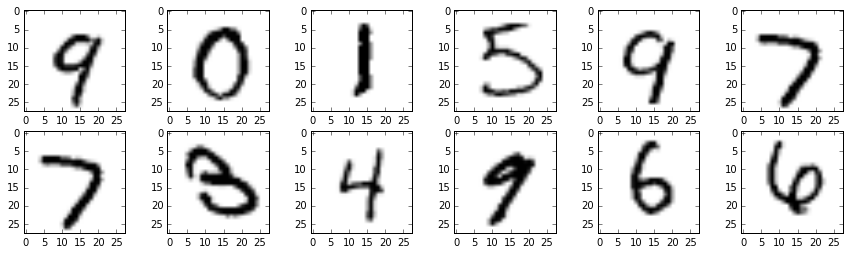

In [22]:
# number of examples to look at
N = 12
N_images, _ = mnist.test.next_batch(N)

f, a = plt.subplots(2, N//2, figsize=(15, 4))
for i in range(N//2):
    a[0][i].imshow(np.reshape(N_images[i], (28, 28)), cmap=plt.cm.Greys)
    a[1][i].imshow(np.reshape(N_images[i+N//2-1], (28, 28)), cmap=plt.cm.Greys)    
plt.draw()

### Try to sample randomly

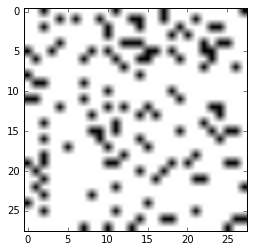

In [23]:
image = np.zeros((28,28))

# N_images, _ = mnist.test.next_batch(1)
# N = np.where(N_images > 0)[0].shape[0]
N = 130
xs = np.random.randint(28, size=N)
ys = np.random.randint(28, size=N)
image[xs,ys] = 1
plt.imshow(image, origin="upper", vmin=0, vmax=1, cmap=plt.cm.Greys)
pass

### Define autoencoder architecture

In [32]:
# Batch size
B = 4096

# latent represenatation dimensionality
LD = 2

#### Decoder

In [70]:
# latent 
z = em.Normal(mu=tf.zeros([B, LD]), sigma=tf.ones([B, LD]))
dlayer1 = tfc.layers.fully_connected(z, num_outputs=256, activation_fn=tf.nn.softplus)
dlayer2 = tfc.layers.fully_connected(dlayer1, num_outputs=512, activation_fn=tf.nn.softplus)
dlayer = dlayer2
dlogits = tfc.layers.fully_connected(dlayer, num_outputs=28*28, activation_fn=None)
x_decoded = em.Bernoulli(logits=dlogits)

#### Encoder

In [71]:
x_input = tf.placeholder(tf.float32, [B, 28*28])
elayer1 = tfc.layers.fully_connected(x_input, num_outputs=512, activation_fn=tf.nn.softplus)
elayer2 = tfc.layers.fully_connected(elayer1, num_outputs=256, activation_fn=tf.nn.softplus)
elayer = elayer2
z_mu = tfc.layers.fully_connected(elayer, num_outputs=LD, activation_fn=None)
z_sg = tfc.layers.fully_connected(elayer, num_outputs=LD, activation_fn=tf.nn.softplus)
qz = em.Normal(mu=z_mu, sigma=z_sg)

In [72]:
inference = ed.KLqp({z: qz}, {x_decoded: x_input})
optimizer = tf.train.AdamOptimizer(0.001)
inference.initialize(optimizer=optimizer)

### Train the autoencoder

In [73]:
LEARNING_RATE = 0.01
BATCH_SIZE = B
N_EPOCHS = 40

sess = ed.get_session()
init = tf.initialize_all_variables()
init.run()

t = time()
for epoch_i in range(N_EPOCHS):
    for batch_i in range(mnist.train.num_examples // BATCH_SIZE):
        batch_data, _ = mnist.train.next_batch(BATCH_SIZE)
        info_dict = inference.update(feed_dict={x_input: batch_data})
    if (epoch_i + 1) % 10 == 0:
        print(epoch_i+1, time()-t)
print("Autoencoder is ready in", time() - t, "seconds")

# save the model to a file
saver = tf.train.Saver()
saver.save(sess, "./ae.model")
print("Autoencoder is saved!")

10 179.10751128196716
20 354.1041316986084
30 529.7232875823975
40 704.1701419353485
Autoencoder is ready in 704.1705276966095 seconds
Autoencoder is saved!


# Show what it has learned

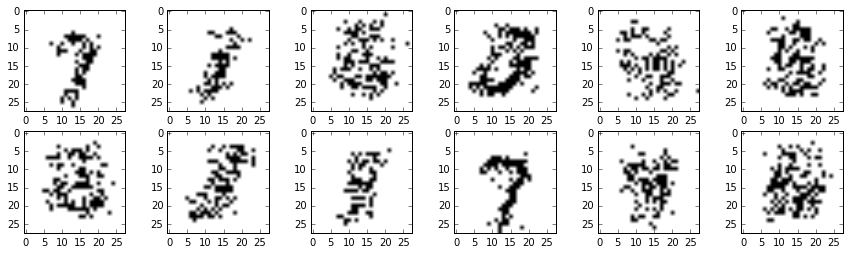

In [74]:
# imgs = sess.run(x_decoded.value())
imgs = x_decoded.value().eval()

N = 12
f, a = plt.subplots(2, N//2, figsize=(15, 4))
for i in range(N//2):
    a[0][i].imshow(np.reshape(imgs[i*2], (28, 28)), cmap=plt.cm.Greys)
    a[1][i].imshow(np.reshape(imgs[i*2+1], (28, 28)), cmap=plt.cm.Greys)
#f.show()
plt.draw()